# 第二章作业
张耀杰 -XJY110224  
读图(Chapter2_1.pgm)、顺时针方向旋转15（利用上述几种插值方法：最近邻、双线性、多项式）、输出图像（测试图像见下图）,可用C++、Matlab、OpenCV、Python编程

提示  
1、为了逐个像素地评估插值运算的影响，建议正反转各15度。  
2、用实验数据证实正反旋转后的图像与原始图像没有位移、也没有灰度大小的比例偏差。  
3、从总体上度量每种插值方法的特性。  
4、对于每种插值方法，给出各自插值效果好以及效果不好的条件（基于实验数据）。   
5、对于每种插值方法，插值与原始图像的误差灰度绝对值的最大值、均值、中值各是多少？分析误差最大值、均值的原因。   


## 一、旋转图片
使用OpenCV或者PIL里内置的相应方法，可以直接调用并完成旋转。但出于首次学习的角度，接下来将手写图片旋转以及插值法的核心代码。  

#### 题目理解：如何完成旋转
对于旋转图片并进行插值处理，一般首先想到的就是将原图片乘以一个旋转矩阵，得到对应坐标后接着使用插值法完成。  
但如果细想其中细节的话我们会发现这种方法存在一个较大的问题，即旋转后的点往往都不是整数坐标，这时候我们很难使用插值法计算出想求的点的灰度值。  
而原图片的灰度值相对来说是比较规整的，如果我们可以逆解出所对应的旋转前点的坐标，我们就可以比较容易的应用插值法计算灰度值。这种方法即向后映射的方法。下图比较形象的展示了两种方式的区别  
![向前映射和向后映射的区别](/Users/zyj/Desktop/python_files/DIP/第二章作业/IMG_9BB6CA675703-1.jpeg)

In [495]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import math
from PIL import Image

%matplotlib inline

In [496]:
img = imread('/Users/zyj/Desktop/python_files/DIP/第二章作业/Chapter2_1.pgm')
print(img)#查看相应PGM的对应矩阵数据结构

[[146 141 139 ... 120 125 129]
 [149 147 142 ... 116 116 116]
 [146 149 146 ... 116 121 125]
 ...
 [ 90  84  82 ...  66  70  70]
 [ 92  90  82 ...  68  68  74]
 [ 92  99  75 ...  76  74  68]]


In [497]:
rows, cols = img.shape
rows, cols

(132, 135)

In [498]:
img[0][0]##原点坐标值，可以看出确实是以灰度值I=146所在的点为原点

146

##### Step 1 求新坐标系的原点以及像素大小
如下图计算旋转后的新的坐标系的新的高宽像素大小，这样我们就得到了旋转后的点$p_1$坐标范围:x[0,new_cols) y[0,new_rows)
![Step 1](/Users/zyj/Desktop/python_files/DIP/第二章作业/Step_1.jpeg)

In [499]:
degree = 15
rad = math.radians(degree)#sin()使用弧度计算，需要将角度转换为对应弧度
def new_cord(rad):
    new_rows = round(cols*math.sin(rad)+rows*math.cos(rad))
    new_cols = round(rows*math.sin(rad)+cols*math.cos(rad))
    return new_rows, new_cols

new_rows, new_cols = new_cord(rad)
new_rows, new_cols

(162, 165)

##### Step 2 坐标变换$p_1$($x_1,y_1,1$) $\rightarrow$ $p_0(x_0,y_0,1)$
现在我们已经有了变换后的坐标$p_1$，需要进行坐标变换，将新坐标变换至原先坐标，在进行一次逆旋转最终得到$p_0$  
数学公式表示为
$$
\vec{p_0} = \vec{p_1} * M_1 * M_2\tag1
$$
1、坐标变换的转换矩阵推导过程如下图所示：
![坐标变换](/Users/zyj/Desktop/python_files/DIP/第二章作业/坐标变换.jpeg)
2、旋转逆变换矩阵推导过程如下图所示：
![旋转矩阵的逆](/Users/zyj/Desktop/python_files/DIP/第二章作业/旋转矩阵求解.jpeg)

M_pan和M_rot分别表示坐标系平移以及旋转的逆矩阵，即上述提到的$M_1, M_2$
$$
M_{pan} = 
\left[
\begin{matrix}
1 & 0 && 0 \\
0 & 1 && 0 \\
-hsin\theta & 0 && 1 
\end{matrix} \tag{2}
\right]
$$
$$
M_{rot} = 
\left[
\begin{matrix}
cos\theta & -sin\theta & 0 \\
sin\theta & cos\theta & 0 \\
0 & 0 & 1 
\end{matrix} \tag{3}
\right]
$$

In [500]:
M_pan = np.array([[1,0,0],[0,1,0],[-rows*math.sin(rad),0,1]])
M_rot = np.array([[math.cos(rad),-math.sin(rad),0],[math.sin(rad),math.cos(rad),0],[0,0,1]])
print(M_pan)
print(M_rot)

[[  1.           0.           0.        ]
 [  0.           1.           0.        ]
 [-34.16411395   0.           1.        ]]
[[ 0.96592583 -0.25881905  0.        ]
 [ 0.25881905  0.96592583  0.        ]
 [ 0.          0.          1.        ]]


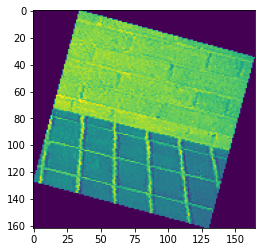

In [501]:
def Nearest():
    new_img = np.zeros((new_rows,new_cols))##初始化新坐标系下的图片
    for j in range(0,new_cols):
        for i in range(0,new_rows):##遍历新图片上的像素点
            p_1 = np.array([j,i,1])
            p_0 = (p_1.dot(M_pan)).dot(M_rot)##对像素点进行坐标转换，得到其在原图中的点的坐标
            x = round(p_0[0])##round()函数可以对非整数进行四舍五入，达到最近临插值的效果
            y = round(p_0[1])
            if(x>=0 and x<cols and y>=0 and y<rows):##若得到的像素点在原图的范围内则返回对应的值给新图
                
                val = img[y][x]
                new_img[i][j] = val
    #使用PIL下的Image工具将所得矩阵转换为pgm格式并保存
    im = Image.fromarray(new_img)
    im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    im.save('Nearest.pgm')
    return new_img
Nearest()
plt.imshow(Nearest())#也可以使用matplotlib中的工具直接将矩阵显示成图片


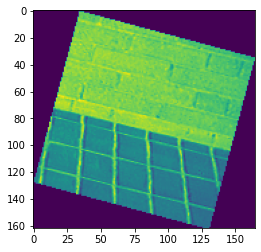

In [502]:
#使用双线性插值法
def Double_linear():
    new_img = np.zeros((new_rows,new_cols))##初始化新坐标系下的图片
    for j in range(0,new_cols):
        for i in range(0,new_rows):
            p_1 = np.array([j,i,1])
            p_0 = (p_1.dot(M_pan)).dot(M_rot)
            x=p_0[0]
            y=p_0[1]
            a = x-int(x)
            b = y-int(y)
            if(x>=0 and x<cols-1 and y>=0 and y<rows-1):
                val_1 = (1-a)*(img[int(y)][int(x)])+a*(img[int(y)][int(x)+1])
                val_2 = (1-a)*(img[int(y)+1][int(x)])+a*(img[int(y)+1][int(x)+1])
                val = (1-b)*val_1+b*val_2
                new_img[i][j]=val
            if(x>cols-1 and x<cols and y>=0 and y<rows-1):#边界特殊情况考虑
                val_1 = (img[int(y)][int(x)])
                val_2 = (img[int(y)+1][int(x)])
                val = (1-b)*val_1+b*val_2
                new_img[i][j]=val
            if(y>rows-1 and y<rows and x>=0 and x<cols-1):#做边界特殊情况考虑
                val_1 = (1-a)*(img[int(y)][int(x)])+a*(img[int(y)][int(x)+1])
                
                val = val_1
                new_img[i][j]=val
                
    #使用PIL下的Image工具将所得矩阵转换为pgm格式并保存
    im = Image.fromarray(new_img)
    im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    im.save('Double_linear.pgm')
    return new_img
plt.imshow(Double_linear())


In [503]:
def abv(x):
    if x>=0:
        return x
    else:
        return -x

def c(x):
    x=abv(x)
    if (x>=0 and x<1):
        return (1-2*x**2+x**3)
    if (x>=1 and x<2):
        return (4-8*x+5*x**2-x**3)
    else:
        return 0


Text(0.5, -0.2, 'Original')

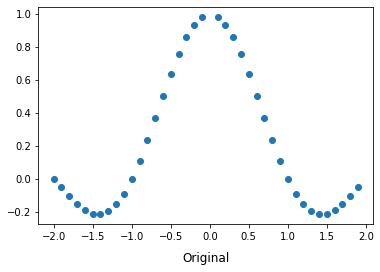

In [504]:
#查看一下c（x）原函数的形状
a = range(-20,20,1)
test_2 = []
test = []
for i in a:
    if (i!=0):
        b=(math.sin(math.pi*i/10))/(math.pi*i/10)
        test.append(b)
        test_2.append(i/10)

plt.scatter(test_2,test)
plt.title('Original',x=0.5,y=-0.2)

A = [c(1 + α ), c(α ), c(1 − α ), c(2 − α )]

In [505]:
#多项式插值的算法
def Cubic_ip(p_0,img):
        x=p_0[0]
        y=p_0[1]
        rows,cols = img.shape
        a = x-int(x)
        b = y-int(y)
        v = int(x)
        u = int(y)
        A = np.array([c(1+a),c(a),c(1-a),c(2-a)])
        C = np.array([c(1+b),c(b),c(1-b),c(2-b)])
        if(u<rows and u>=rows-1):#边界情况特殊处理
            u = u-1
        if(u<rows-1 and u>=rows-2):#边界情况特殊处理
            u = u-1
        if(v<cols and v>=cols-1):#边界情况特殊处理
            v = v-1
        if(v<cols-1 and v>=cols-2):#边界情况特殊处理
            v = v-1
            
        C.transpose()
        B = np.array([[img[u-1][v-1],img[u][v-1],img[u+1][v-1],img[u+2][v-1]],
                [img[u-1][v],img[u][v],img[u+1][v],img[u+2][v]],
                [img[u-1][v+1],img[u][v+1],img[u+1][v+1],img[u+2][v+1]],
                [img[u-1][v+2],img[u][v+2],img[u+1][v+2],img[u+2][v+2]]
                ])#由于以rows为纵坐标，cols为横坐标，注意这里的u，v位置和习惯上的写法是相反的
        

        val=(A.dot(B)).dot(C)
        return val
        
        

Text(0.5, -0.2, 'Cubic_linear')

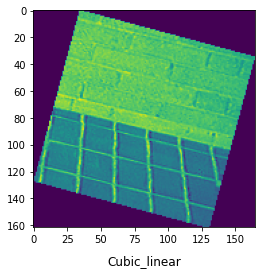

In [506]:
def Cubic_linear():
    new_img = np.zeros((new_rows,new_cols))##初始化新坐标系下的图片
    for j in range(0,new_cols):
        for i in range(0,new_rows):
            p_1 = np.array([j,i,1])
            p_0 = (p_1.dot(M_pan)).dot(M_rot)
            x=p_0[0]
            y=p_0[1]           
            if(x>=0 and x<cols and y>=0 and y<rows):
                val = Cubic_ip(p_0,img)
                new_img[i][j]=val
            
    #使用PIL下的Image工具将所得矩阵转换为pgm格式并保存
    im = Image.fromarray(new_img)
    im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    im.save('Double_linear.pgm')
    return new_img
plt.imshow(Cubic_linear())
plt.title('Cubic_linear',x=0.5,y=-0.2)

In [507]:
def Nearest_ip(p_0,img):
    x = round(p_0[0])
    y = round(p_0[1])
    val = img[y][x]
    return val

使用同样的方法，运行一次逆变换，将得到的新图像旋转回去

Text(0.5, -0.2, 'Nearest_reverse')

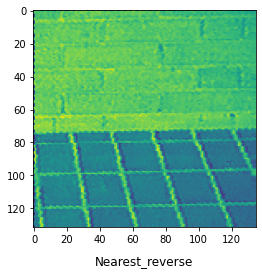

In [508]:
M_pan_1 = np.array([[1,0,0],[0,1,0],[rows*math.sin(rad),0,1]])
M_rot_1 = np.array([[math.cos(rad),math.sin(rad),0],[-math.sin(rad),math.cos(rad),0],[0,0,1]])
def Nearest_reverse():
    new_img = Cubic_linear()
    double_img = np.zeros((rows,cols))
    for j in range(0,cols):
        for i in range(0,rows):
            p_1 = np.array([j,i,1])
            p_0 = (p_1.dot(M_rot_1)).dot(M_pan_1)
            x = round(p_0[0])
            y = round(p_0[1])
            if(x>=0 and x<new_cols and y>=0 and y<new_rows):
                val = new_img[y][x]
                double_img[i][j] = val
    #使用PIL下的Image工具将所得矩阵转换为pgm格式并保存
    im = Image.fromarray(new_img)
    im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    im.save('Nearest_reverse.pgm')
    return double_img
plt.imshow(Nearest_reverse())
plt.title('Nearest_reverse',x=0.5,y=-0.2)

In [509]:
def Double_ip(p_0,img):
    x=p_0[0]
    y=p_0[1]
    a = x-int(x)
    b = y-int(y)
    if(x>new_cols-1 and x<new_cols and y>=0 and y<new_rows-1):
        val_1 = (img[int(y)][int(x)])
        val_2 = (img[int(y)+1][int(x)])
        val = (1-b)*val_1+b*val_2
    if(y>new_rows-1 and y<new_rows and x>=0 and x<new_cols-1):
        val_1 = (1-a)*(img[int(y)][int(x)])+a*(img[int(y)][int(x)+1])
        val = val_1
    else:
        val_1 = (1-a)*(img[int(y)][int(x)])+a*(img[int(y)][int(x)+1])
        val_2 = (1-a)*(img[int(y)+1][int(x)])+a*(img[int(y)+1][int(x)+1])
        val = (1-b)*val_1+b*val_2

    return val

Text(0.5, -0.2, 'Double_reverse')

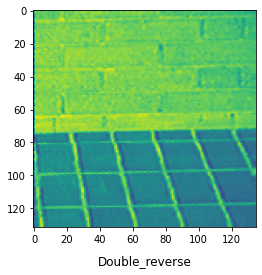

In [510]:
def Double_reverse():
    new_img = Cubic_linear()
    double_img = np.zeros((rows,cols))
    for j in range(0,cols):
        for i in range(0,rows):
            p_1 = np.array([j,i,1])
            p_0 = (p_1.dot(M_rot_1)).dot(M_pan_1)
            x = p_0[0]
            y = p_0[1]
            if(x>=0 and x<new_cols and y>=0 and y<new_rows):
                val = Double_ip(p_0,new_img)
                double_img[i][j] = val
    #使用PIL下的Image工具将所得矩阵转换为pgm格式并保存
    im = Image.fromarray(new_img)
    im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    im.save('Double_reverse.pgm')
    return double_img
plt.imshow(Double_reverse())
plt.title('Double_reverse',x=0.5,y=-0.2)

Text(0.5, -0.2, 'Cubic_reverse')

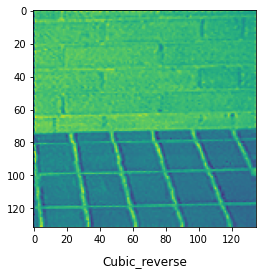

In [511]:
def Cubic_reverse():
    new_img = Cubic_linear()
    cubic_img = np.zeros((rows,cols))
    for j in range(0,cols):
        for i in range(0,rows):
            p_1 = np.array([j,i,1])
            p_0 = (p_1.dot(M_rot_1)).dot(M_pan_1)
            x = p_0[0]
            y = p_0[1]
            if(x>=0 and x<new_cols and y>=0 and y<new_rows):
                val = Cubic_ip(p_0,new_img)
                cubic_img[i][j] = val
    #使用PIL下的Image工具将所得矩阵转换为pgm格式并保存
    im = Image.fromarray(new_img)
    im = im.convert('L')  # 这样才能转为灰度图，如果是彩色图则改L为‘RGB’
    im.save('Double_reverse_bad.pgm')
    return cubic_img
plt.imshow(Cubic_reverse())
plt.title('Cubic_reverse',x=0.5,y=-0.2)

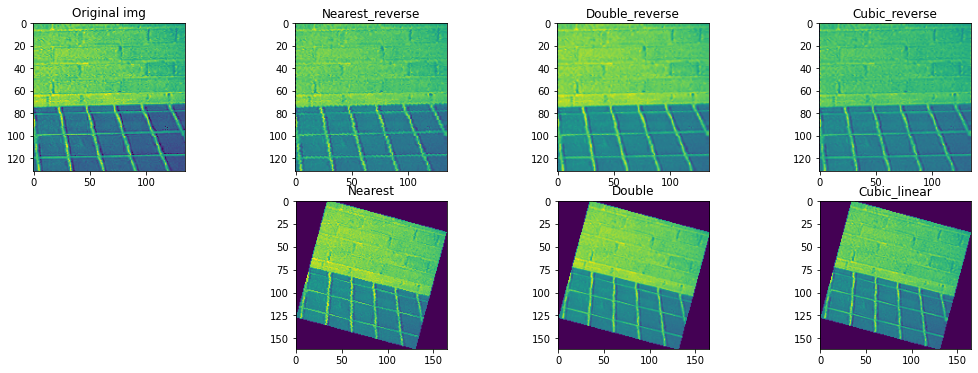

In [512]:
plt.figure(figsize=(18, 6))
all = [img, Nearest_reverse(),Double_reverse(),Cubic_reverse()]
plt.subplot(241)
plt.imshow(img)
plt.title('Original img')
plt.subplot(242)
plt.imshow(Nearest_reverse())
plt.title('Nearest_reverse')
plt.subplot(243)
plt.imshow(Double_reverse())
plt.title('Double_reverse')
plt.subplot(244)
plt.imshow(Cubic_reverse())
plt.title('Cubic_reverse')
plt.subplot(246)
plt.imshow(Nearest())
plt.title('Nearest')
plt.subplot(247)
plt.imshow(Double_linear())
plt.title('Double')
plt.subplot(248)
plt.imshow(Cubic_linear())
plt.title('Cubic_linear')
plt.show()


### 二、结果分析

#### 1、用实验数据证实正反旋转后的图像与原始图像没有位移、也没有灰度大小的比例偏差。

Text(0.5, -0.1, 'Cubic')

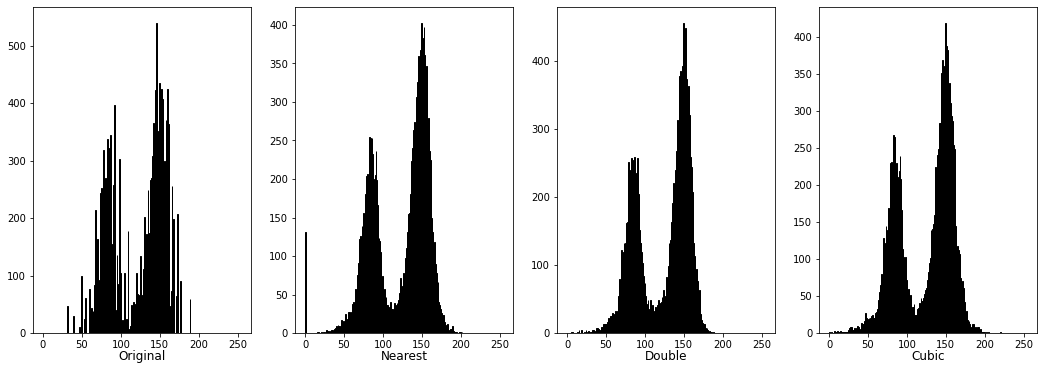

In [513]:
#查看旋转后的图片的灰度直方图分布
plt.figure(figsize=(18,6))
plt.subplot(141)
Original = plt.hist(img.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Original',x=0.5,y=-0.1) 
plt.subplot(142)
Nearest_hist = plt.hist(Nearest_reverse().ravel(), bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Nearest',x=0.5,y=-0.1)
plt.subplot(143)
Double_hist = plt.hist(Double_reverse().ravel(), bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Double',x=0.5,y=-0.1)
plt.subplot(144)
Cubic_hist = plt.hist(Cubic_reverse().ravel(), bins=256, range=(0, 255), fc='k', ec='k')
plt.title('Cubic',x=0.5,y=-0.1)

从灰度直方图可以看出旋转后的图片与原图片分布基本一致。

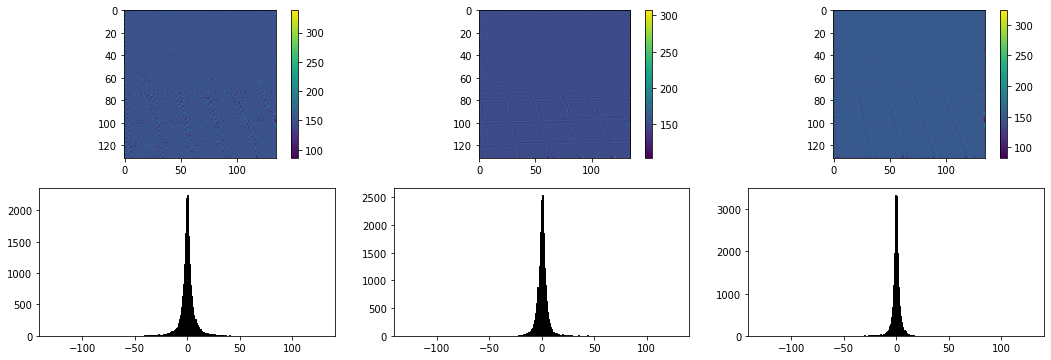

In [514]:
#将原图像与旋转恢复后的图像做差，观察分布情况，为了使得图片效果明显，显示的时候加入150灰度值的偏置（人眼对此灰度附近的变化率较敏感）
Nearest_sub = img - Nearest_reverse()+150*np.ones((rows,cols))
Double_sub = img - Double_reverse()+150*np.ones((rows,cols))
Cubic_sub = img - Cubic_reverse()+150*np.ones((rows,cols))
plt.figure(figsize=(18,6))
plt.subplot(231)
plt.imshow(Nearest_sub)
plt.colorbar()
plt.subplot(234)
Nearest_sub_hist = plt.hist(Nearest_sub.ravel()-150, bins=256, range=(-128, 128), fc='k', ec='k')
plt.subplot(232)
plt.imshow(Double_sub)
plt.colorbar()
plt.subplot(235)
Double_sub_hist = plt.hist(Double_sub.ravel()-150, bins=256, range=(-128, 128), fc='k', ec='k')
plt.subplot(233)
plt.imshow(Cubic_sub)
plt.colorbar()
plt.subplot(236)
Cubic_sub_hist = plt.hist(Cubic_sub.ravel()-150, bins=256, range=(-128, 128), fc='k', ec='k')
plt.show()

可以从图片中看出没有发生位移，并且直方图呈现出以**0为中心的正态分布**，表明图片没有发生位移以及比例偏差。否则直方图将发生明显偏移。

注：若使用原先的Nearest插值得到的新图像，会发现Nearest_reverse()得到的方法异常的好。分析其原因，是旋转前后恰好大部分点选择了原图像的像素点，导致和原图像基本一致。而对于双线性或Cubic，从新得到的图形旋转回原先图像会导致误差的累计，打比方好比两次高斯误差的累加。在这种情况下与最近邻方法直接比较是有失公平的。  
因此reverse统一使用Cubic_linear或Double_linear中生成的图像，分析结果更具有一般性。

#### 2、从总体上度量每种插值方法的特性

1）PSNR
PSNR是“Peak Signal to Noise Ratio”的缩写，即峰值信噪比，是一种用于评价图像或语音信号的客观标准，通常在经过压缩之后，输出的影像都会在某种程度与原始影像不同。为了衡量经过处理后的影像品质，我们通常会参考PSNR值来衡量某个处理步骤能否令人满意。它是原图像与被处理图像之间的均方误差相对于  的对数值(信号最大值的平方，n是每个采样值的比特数)，它的单位是dB。（取自google）


In [515]:
from math import log10, sqrt
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

array([25.06658387, 27.68155125, 27.56724263])

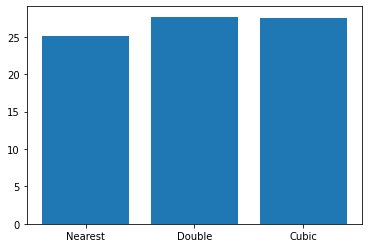

In [516]:
data = np.array([PSNR(img, Nearest_reverse()),PSNR(img, Double_reverse()),PSNR(img, Cubic_reverse())])
index = ['Nearest','Double','Cubic']
PSNR_bar = plt.bar(index,data)
data

2) 结构相似性指数（structural similarity index，SSIM）[2]，用于度量两幅图像间的结构相似性。与被广泛采用的L2 loss不同，SSIM和人类的视觉系统（HVS）类似，对局部结构变化的感知敏感。SSIM分为三个部分：照明度、对比度、结构.  
PSNR与SSIM都是通过计算待评图像与参考图像之间像素误差的全局大小来衡量图像质量好坏的。PSNR值越大，表明待评图像与参考图像之间的失真较小，图像质量较好。这两种方法比较简单，且容易实现，在图像去噪等方面受到广泛应用。但这类算法是从图像像素值的全局统计出发，未考虑人眼的局部视觉因素，所以对于图像局部质量无从把握。（取自Google）

In [517]:
#1. Import the required packets
from skimage.measure import compare_ssim
import argparse
import imutils

In [518]:

methods = [Nearest_reverse(),Double_reverse(),Cubic_reverse()]
scores=[]
for i in methods:
    (score, diff) = compare_ssim(img, i, full=True)
    diff = (diff * 255).astype("uint8")
    print("SSIM: {}".format(score))
    scores.append(score)
scores

SSIM: 0.8948862297504889
SSIM: 0.9286024068362949
SSIM: 0.956502884684533


<ipython-input-518-7b6729aba487>:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  (score, diff) = compare_ssim(img, i, full=True)
/Users/zyj/opt/anaconda3/lib/python3.8/site-packages/skimage/measure/_structural_similarity.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return structural_similarity(X, Y, win_size=win_size, gradient=gradient,


[0.8948862297504889, 0.9286024068362949, 0.956502884684533]

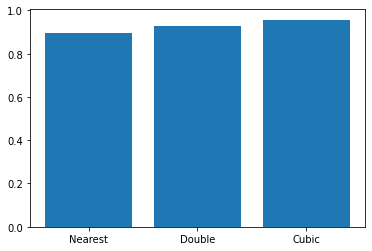

In [519]:
SSIM_bar = plt.bar(index,scores)

小结：PSNR和SSIM的值可以看出，总体上Cubic的效果最好，Double次之，Nearest相对最差。

#### 4. 对于每种插值方法，给出各自插值效果好以及效果不好的条件（基于实验数据）。  

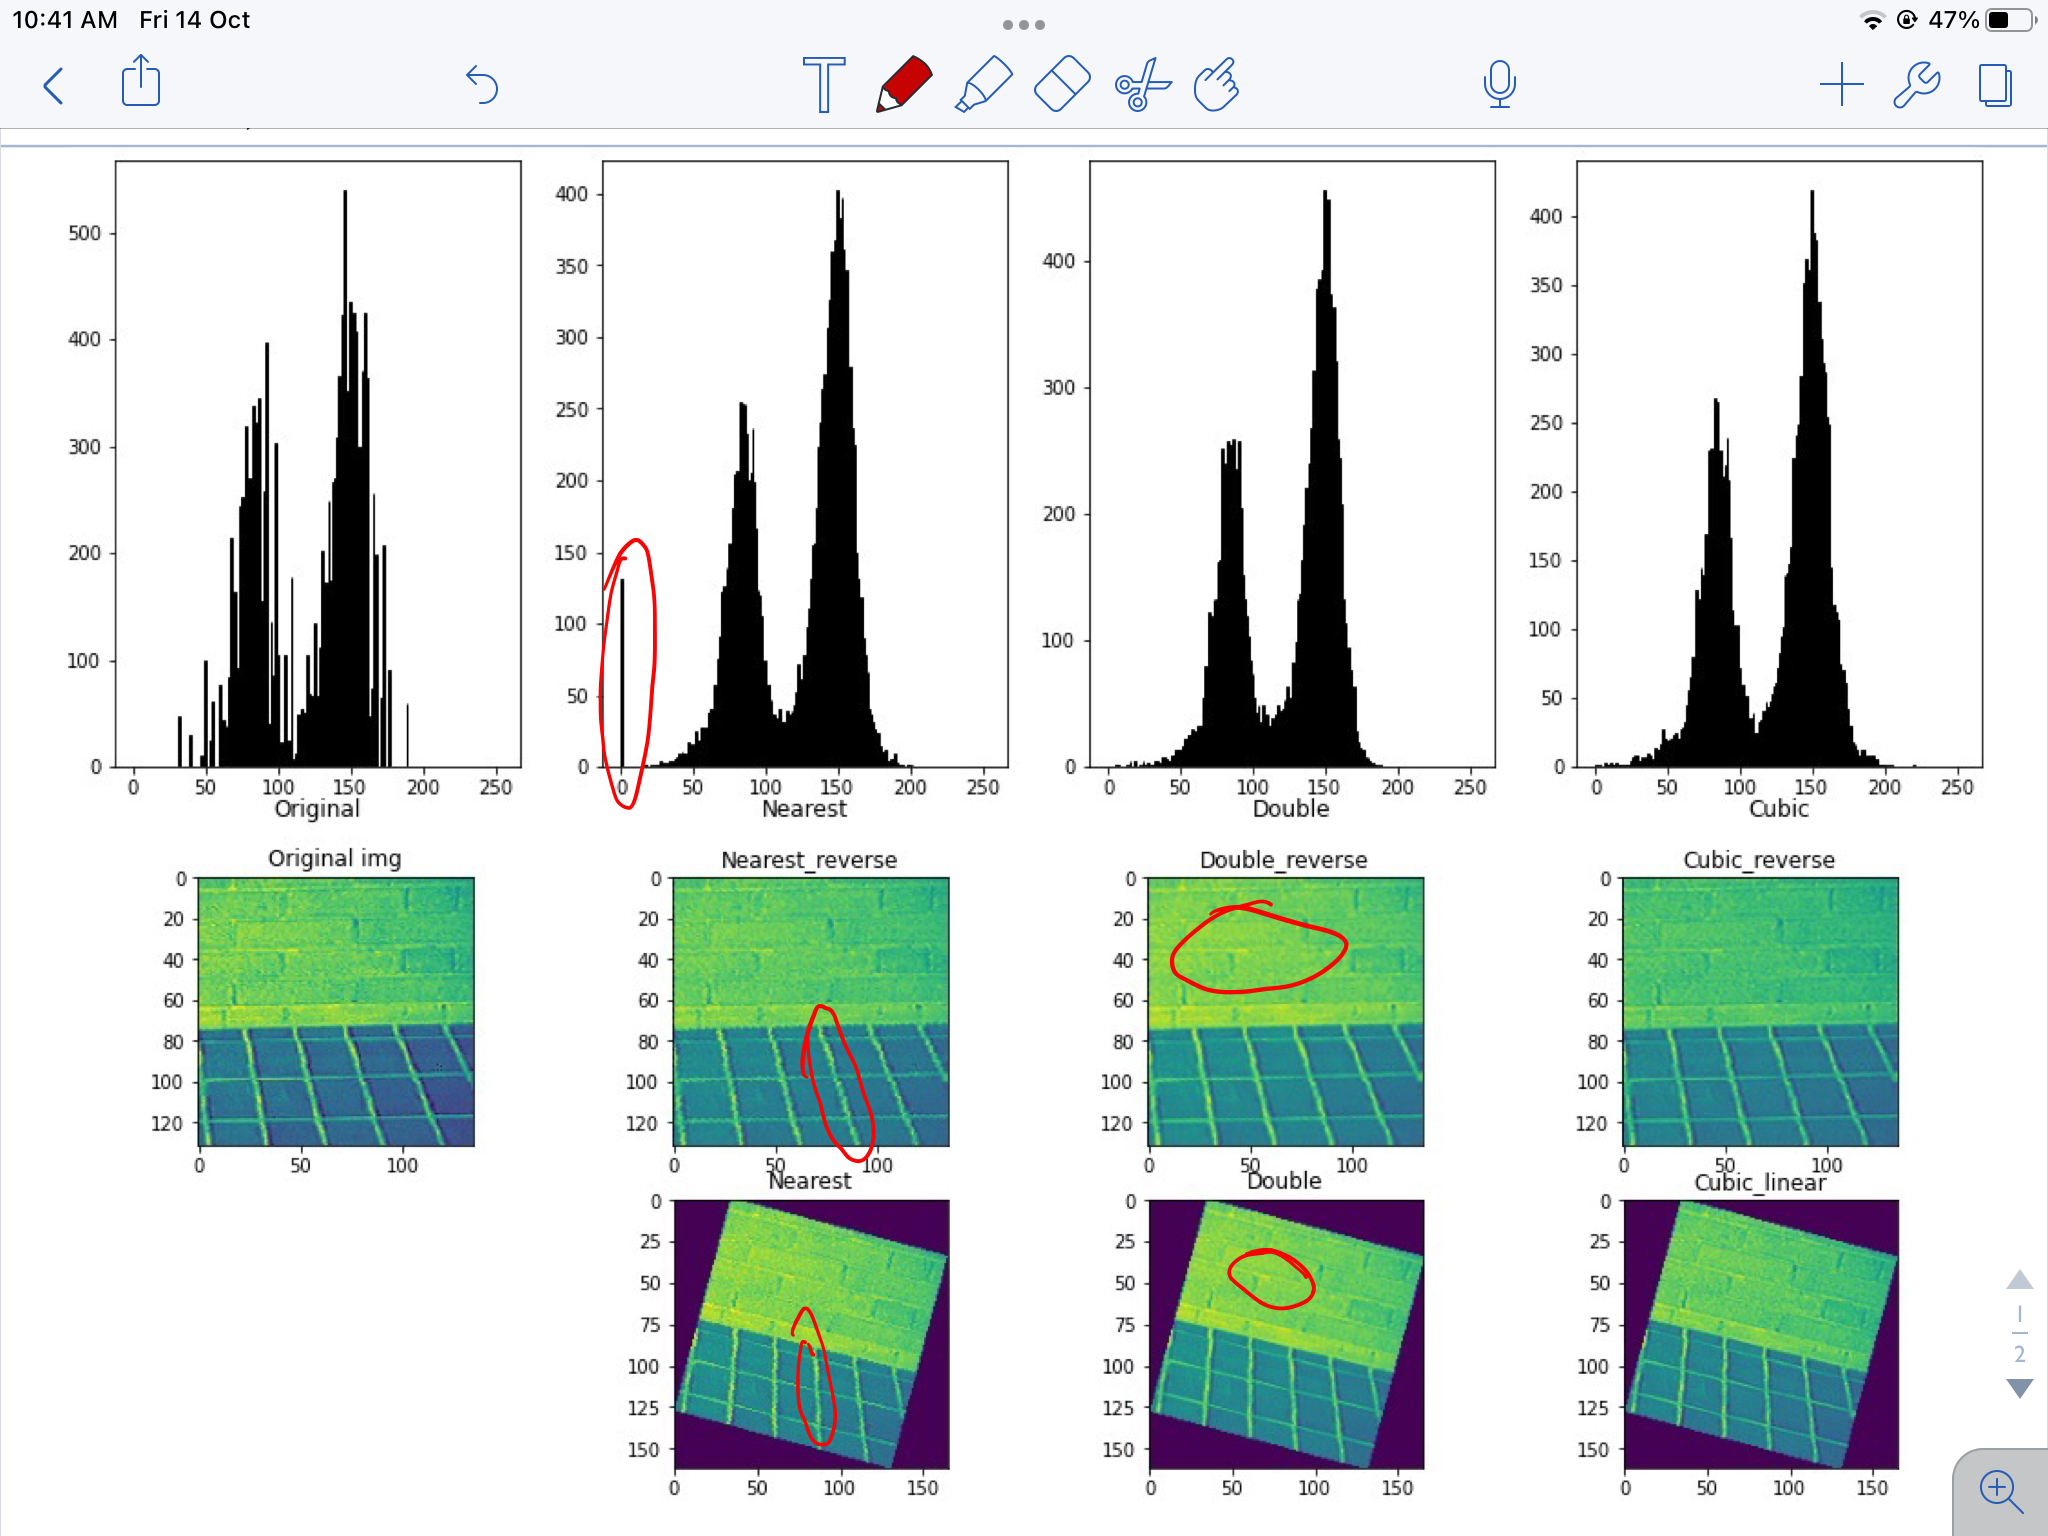
由上图可以看出，对于最近邻插值法，当在灰度差异较大的边缘时，误差较大，锯齿效应明显。  
对于双线性，已经较好的处理了边缘锯齿的问题，在边缘看起来较平滑。但是由于其具有低通滤波性质，可以看出其在某些局部位置模糊比较严重，细节丢失较多。  
总体上，多项式保存的细节比较好，精度较高，但主要缺点是使用精度越高的逼近函数，其计算量越大。



#### 5. 对于每种插值方法，插值与原始图像的误差灰度绝对值的最大值、均值、中值各是多少？分析误差最大值、均值的原因。

In [520]:
(np.around(Nearest_sub)-150).max(), (np.around(Double_sub)-150).max(),(np.around(Cubic_sub)-150).max()#之前算各自sub时做了+150灰度值处理，这里统计信息的处理需要注意减去

(189.0, 158.0, 175.0)

In [521]:
(np.around(Nearest_sub)-150).mean(), (np.around(Double_sub)-150).mean(),(np.around(Cubic_sub)-150).mean()

(0.938608305274972, 0.9857463524130191, 0.6799102132435466)

In [522]:
np.median((np.around(Nearest_sub)-150)), np.median((np.around(Double_sub)-150)),np.median((np.around(Cubic_sub)-150))

(0.0, 0.0, 0.0)

In [523]:
np.var((np.around(Nearest_sub)-150)), np.var((np.around(Double_sub)-150)),np.var((np.around(Cubic_sub)-150))

(201.68736461761895, 109.98711445418142, 113.40921480675316)

每种插值方法的统计信息如下：

|    | Nearest|Double Linear|Cubic|
|:----:|:----:|:----:|:----|
| Max  |  189| 158 |   175 |
|  Mean | 0.94 | 0.99  | 0.68   |
| Median  | 0  |  0  |   0 |
|Variance|201.69|109.99|113.40|

最近邻插值算法的灰度误差出现了最大值，因为它只考虑了最近像素点，而忽略了其他邻域消息，一旦选取了非相关的点插值，尤其是边缘信息的时候，产生的绝对误差是最大的。
三种插值方法的均值误差都比较小，因为计算平均值时会将正负项相抵消，理论上是一个一个期望为0的高斯分布，不能较好的比较插值方法的优劣，因此这里以方差作为评判的标准。  
邻近算法的方差最大，在整张图片的统计意义上，其匹配效果不如其余两种插值法。   
中值都为0，表示整体上匹配效果较好